# Import Library

In [1]:
!pip install natsort

In [2]:
import os, os.path as osp
from glob import glob
from natsort import os_sorted
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Input parameter /  Load csv path

In [312]:
# split train folder into train and validation
split_train = 0.80
# Input folder data
input_dir = '/kaggle/input/human-activity-recognition-har/HAR'

train_dir = input_dir + '/train'
test_dir = input_dir + '/test'
df_paths = glob(osp.join(train_dir, '*', '*.csv'))

# Visualize DataFrame

In [286]:
def plot_activity(activity,df,start=0,stop=200):
    df = df.iloc[start:stop]

    ax = df.plot(subplots=True,figsize=(16,12),title=activity+ ', Start Row: '+str(start)+' Stop row: '+str(stop)) # Plot accelerometer for the activity.

In [ ]:
path = df_paths[0]
activity, filename = path.split('/')[-2:]
df = pd.read_csv(path)
plot_activity(activity, df)

In [288]:
df.value_counts

<bound method DataFrame.value_counts of       x-axis  y-axis  z-axis
0       5.94    1.88    8.20
1       6.05    1.92    8.39
2       5.67    1.92    8.16
3       5.24    1.95    8.31
4       5.48    1.99    8.39
...      ...     ...     ...
1462    5.01    1.57    8.54
1463    5.48    1.57    8.85
1464    5.37    1.50    8.62
1465    5.41    1.38    8.58
1466    5.52    1.57    8.47

[1467 rows x 3 columns]>

In [ ]:
plot_activity(activity,df,100,500)

# Training, Validation Data

We'll use 80% of the measurements for training and validation.

In [313]:
from sklearn.model_selection import train_test_split

dataset_paths = {'train': [], 'val': []}

for activity_dir in glob(osp.join(train_dir, '*')):
    paths = glob(osp.join(activity_dir, '*.csv'))
    train_paths, val_paths = train_test_split(paths,test_size= (1-split_train ),random_state=42)
    dataset_paths['train'].extend(train_paths)
    dataset_paths['val'].extend(val_paths)

In [314]:
len(dataset_paths['train']), len(dataset_paths['val'])

(111, 32)

In [292]:
df.value_counts

<bound method DataFrame.value_counts of       x-axis  y-axis  z-axis
0       5.94    1.88    8.20
1       6.05    1.92    8.39
2       5.67    1.92    8.16
3       5.24    1.95    8.31
4       5.48    1.99    8.39
...      ...     ...     ...
1462    5.01    1.57    8.54
1463    5.48    1.57    8.85
1464    5.37    1.50    8.62
1465    5.41    1.38    8.58
1466    5.52    1.57    8.47

[1467 rows x 3 columns]>

# Load Dataset

In [315]:

# Parameter for data segmentation
frame_len = 100
hop_len = 50
def frame(x, frame_len, hop_len):
    '''Slice a 3D data array into (overlapping) frames.

    Example
    --------
    >>> x = np.array([[0, 1, 2],
                      [10, 11, 12],
                      [20, 21, 22],
                      [30, 31, 32],
                      [40, 41, 42],
                      [50, 51, 52],
                      [60, 61, 62]])
    >>> frames = x.frame(x, 3, 2)
    >>> x.shape
    (7, 3)
    >>> frames.shape
    (3, 3, 3)
    '''

    assert(x.shape[0] >= frame_len)
    assert(hop_len >= 1)

    n_frames = 1 + (x.shape[0] - frame_len) // hop_len
    shape = (n_frames, frame_len, x.shape[1])
    strides = ((hop_len * x.strides[0],) + x.strides)
    return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)
    
# Parameter for data segmentation
frame_len = 100
hop_len = 50


**Load and preprocess data**

In [294]:
df=pd.read_csv(path)
df.columns

Index(['x-axis', 'y-axis', 'z-axis'], dtype='object')

In [316]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA

dataset_blocks = {'train': {'block': [], 'label': []},
                  'val': {'block': [], 'label': []}}

for dataset in ['train', 'val']:
    paths = dataset_paths[dataset]

    for path in paths:
        activity = path.split(os.sep)[-2]
        df = pd.read_csv(path)
        df['magnitude'] = np.sqrt(df['x-axis']**2 + df['y-axis']**2 + df['z-axis']**2)
        #df[f'x_roll_mean'] = df['x-axis'].rolling(window=100).mean()
        #df[f'x_roll_std'] = df['x-axis'].rolling(window=100).std()
        #df.fillna(method='bfill', inplace=True)
        # Preprocessing
        mms = MinMaxScaler()
        for feature in list(df.columns):
            #pca = PCA()
            #df[feature] = pca.fit_transform(df[[feature]])
            df[feature] = mms.fit_transform(df[[feature]])
        
        samples = frame(df.loc[:, ].values, frame_len, hop_len)
        labels = np.full(samples.shape[0], activity)

        dataset_blocks[dataset]['block'].extend(samples)
        dataset_blocks[dataset]['label'].extend(labels)

    dataset_blocks[dataset]['block'] = np.array(dataset_blocks[dataset]['block'])
    dataset_blocks[dataset]['label'] = np.array(dataset_blocks[dataset]['label'])

In [317]:
dataset_blocks['train']['block'].shape, dataset_blocks['val']['block'].shape

((13407, 100, 4), (4027, 100, 4))

In [318]:
dataset_blocks['val']['label'][:10]

array(['Sitting', 'Sitting', 'Sitting', 'Sitting', 'Sitting', 'Sitting',
       'Sitting', 'Sitting', 'Sitting', 'Sitting'], dtype='<U10')

**One Hot Encode Labels**

In [231]:
df.head(8)

,x-axis,y-axis,z-axis,magnitude,x_roll_mean,y_roll_mean,z_roll_mean
0,0.433851,0.421979,0.457586,0.110448,0.2503,0.666741,0.379886
1,0.599309,0.631093,0.478385,0.298432,0.2503,0.666741,0.379886
2,0.465630,0.927892,0.351550,0.692285,0.2503,0.666741,0.379886
3,0.351986,0.743294,0.447390,0.478515,0.2503,0.666741,0.379886
4,0.410017,0.913758,0.418842,0.680926,0.2503,0.666741,0.379886
5,0.889119,0.980963,0.637847,0.894163,0.2503,0.666741,0.379886
6,0.681174,0.573118,0.493883,0.276867,0.2503,0.666741,0.379886
7,0.548877,0.454860,0.453507,0.061073,0.2503,0.666741,0.379886


In [232]:
df['x_roll_mean'].value_counts

<bound method IndexOpsMixin.value_counts of 0       0.250300
1       0.250300
2       0.250300
3       0.250300
4       0.250300
          ...   
9588    0.747109
9589    0.733554
9590    0.734417
9591    0.733704
9592    0.730963
Name: x_roll_mean, Length: 9593, dtype: float64>

In [233]:
df.head(2)

,x-axis,y-axis,z-axis,magnitude,x_roll_mean,y_roll_mean,z_roll_mean
0,0.433851,0.421979,0.457586,0.110448,0.2503,0.666741,0.379886
1,0.599309,0.631093,0.478385,0.298432,0.2503,0.666741,0.379886


In [319]:
LABELS = os_sorted([osp.split(path)[-1] for path in glob(osp.join(train_dir, '*'))])
LABELS

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

In [320]:
for dataset in ['train', 'val']:
    labels = dataset_blocks[dataset]['label']
    one_hot_encoded = np.zeros((labels.size, len(LABELS)))

    for i, label in enumerate(LABELS):
        index = np.where(labels == label)[0]
        one_hot_encoded[index, i] = 1

    dataset_blocks[dataset]['label'] = one_hot_encoded

In [321]:
dataset_blocks['val']['label'][:10]

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]])

**Visualize**

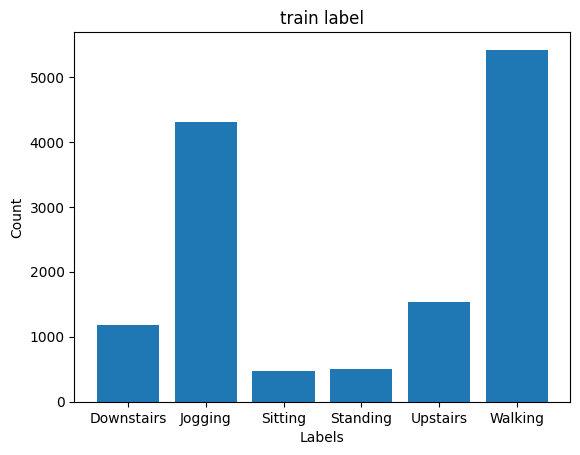

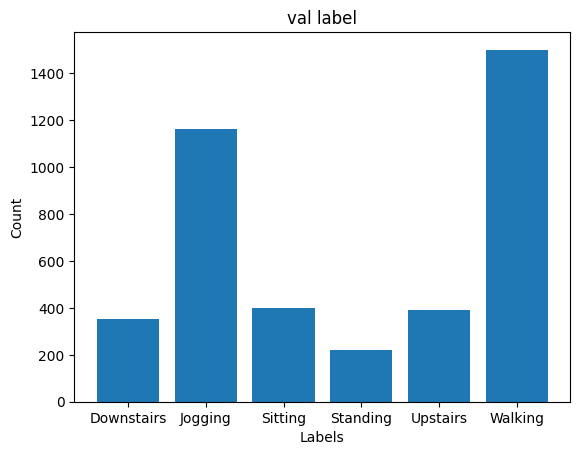

In [322]:
for dataset in ['train', 'val']:
    labels = dataset_blocks[dataset]['label']

    labels_sum = labels.sum(axis=0)

    # Plotting
    plt.bar(LABELS, labels_sum)
    plt.title(f'{dataset} label')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

# Model

In [323]:
# Get the input shape -> (samples, time steps, features)
X_train = dataset_blocks['train']['block']
Y_train = dataset_blocks['train']['label']

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]
print('n_timesteps: {}, n_features: {}, n_outputs: {}'.format(n_timesteps,n_features,n_outputs))

n_timesteps: 100, n_features: 4, n_outputs: 6


In [324]:
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Input, Dense, Dropout, Flatten

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath= '/kaggle/working/best_cnn_model.weights.h5',
        monitor='val_loss', save_best_only=True, save_weights_only=True
    ),
]

In [325]:
window_size=100
num_features=4

In [326]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

# CRNN Model with increased layers
crnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, num_features)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(100, return_sequences=True),
    LSTM(100),
    Dense(100, activation='relu'),
    Dense(6, activation='softmax')
])

crnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
crnn_model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)              │ (None, 98, 64)         │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_30 (MaxPooling1D) │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 47, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_31 (MaxPooling1D) │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 23, 100)        │        91,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,242 (813.45 KB)

 Trainable params: 208,242 (813.45 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
'''
model = Sequential()
model.add(Input(shape=(n_timesteps,n_features)))
model.add(Conv1D(16, 8, activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(n_outputs, activation='softmax'))


model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


**Training**

In [332]:
history = crnn_model.fit(dataset_blocks['train']['block'],
                    dataset_blocks['train']['label'],
                    epochs=20,
                    batch_size=128,
                    validation_data=(dataset_blocks['val']['block'],
                                     dataset_blocks['val']['label']),
                    callbacks=callbacks_list,
                    verbose=1)

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9804 - loss: 0.0505 - val_accuracy: 0.8830 - val_loss: 0.4964
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9898 - loss: 0.0270 - val_accuracy: 0.8945 - val_loss: 0.5491
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9920 - loss: 0.0212 - val_accuracy: 0.8858 - val_loss: 0.6342
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9861 - loss: 0.0379 - val_accuracy: 0.8699 - val_loss: 0.5344
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9904 - loss: 0.0284 - val_accuracy: 0.8791 - val_loss: 0.5967
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9901 - loss: 0.0283 - val_accuracy: 0.8756 - val_loss: 0.5861
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9938 - loss: 0.0185 - val_accuracy: 0.8674 - val_loss: 0.7148
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9844 - loss: 0.0476 - val_accur

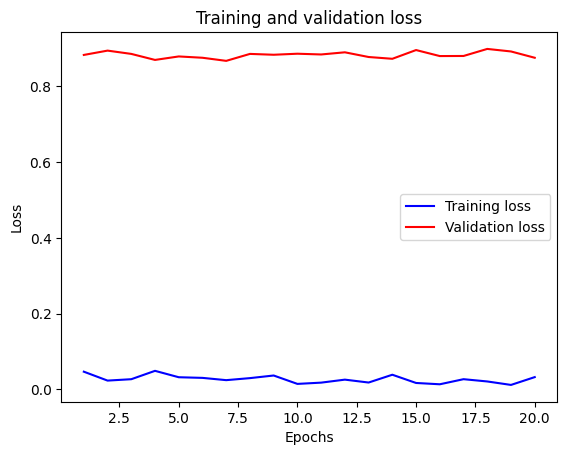

In [333]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'b', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

    boosting_type='gbdt',        # Gradient Boosting Decision Tree
    objective='multiclass',      # Multiclass classification
    num_class=len(np.unique(y_train)),  # Number of classes
    metric='multi_logloss',      # Metric to optimize
    num_leaves=31,               # Maximum number of leaves in one tree
    learning_rate=0.05,          # Learning rate
    feature_fraction=0.9,        # Percentage of features to consider
    bagging_fraction=0.8,        # Percentage of data samples to use
    bagging_freq=5,              # Frequency for bagging
    verbose=0 

In [251]:
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Assuming dataset_blocks is prepared with 'train' and 'val' splits
X_train, y_train = dataset_blocks['train']['block'], dataset_blocks['train']['label']
X_val, y_val = dataset_blocks['val']['block'], dataset_blocks['val']['label']

# Convert one-hot encoded labels to categorical labels (if needed)
if y_train.ndim > 1:
    y_train = np.argmax(y_train, axis=1)
if y_val.ndim > 1:
    y_val = np.argmax(y_val, axis=1)

# Define LightGBM classifier
lgbm_classifier = LGBMClassifier()

# Train the model
X_train = X_train.reshape(X_train.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
lgbm_classifier.fit(X_train, y_train)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 178500
[LightGBM] [Info] Number of data points in the train set: 14612, number of used features: 700
[LightGBM] [Info] Start training from score -2.418710
[LightGBM] [Info] Start training from score -1.115730
[LightGBM] [Info] Start training from score -3.365040
[LightGBM] [Info] Start training from score -3.256319
[LightGBM] [Info] Start training from score -2.159484
[LightGBM] [Info] Start training from score -0.929344


LGBMClassifier()

In [254]:
X_val = X_val.reshape(X_val.shape[0], -1)
# Predictions
y_pred = lgbm_classifier.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')


Validation Accuracy: 0.7799


**Validation**

In [334]:
# evaluate model
loss, accuracy = crnn_model.evaluate(dataset_blocks['val']['block'],
                                dataset_blocks['val']['label'], batch_size=128, verbose=0)
print(f'Loss : {loss}')
print(f'Accuracy: {accuracy}')

Loss : 0.7070478200912476
Accuracy: 0.8755897879600525


# Submission

In [335]:
from sklearn.preprocessing import StandardScaler

answer_list = []

for filename in tqdm(glob(test_dir + '/*.csv')):
      
    # Read test csv file
    df = pd.read_csv(filename)
    df['magnitude'] = np.sqrt(df['x-axis']**2 + df['y-axis']**2 + df['z-axis']**2)
    #df[f'x_roll_mean'] = df['x-axis'].rolling(window=100).mean()
    #df[f'x_roll_std'] = df['x-axis'].rolling(window=100).std()
    #df.fillna(method='bfill', inplace=True)
    # Preprocessing
    mms = MinMaxScaler()
    for feature in list(df.columns):
        #pca = PCA()
        #df[feature] = pca.fit_transform(df[[feature]])
        df[feature] = mms.fit_transform(df[[feature]])

    samples = df.loc[:, ].values
    
    # Predict
    y_pred_prob = crnn_model.predict(np.array(samples).reshape(-1,frame_len,n_features), verbose = 0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    class_names = LABELS[y_pred[0]]
    
    value = (filename.split('/')[-1], class_names)
    answer_list.append(value)

100%|██████████| 693/693 [00:58<00:00, 11.86it/s]


In [336]:
import pandas as pd
column_name = ['id','class']
xml_df = pd.DataFrame(answer_list, columns=column_name)
xml_df.to_csv('/kaggle/working/numberone.csv', index=None)